In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
from tqdm.notebook import tqdm
from scipy.interpolate import CubicSpline

%matplotlib notebook

In [65]:
#CONSTANTS

h = 1.0546e-27
c = 2.9979e10
kb = 1.3807e-16
mp = 1.6726e-24
me = 9.1094e-28
e = 4.8032e-10
NA = 6.0221408e23 
G = 6.6743e-8
solar_M = 1.989e33

In [66]:
heatfluxdata = np.loadtxt('Data/grid_He9.txt')    

In [141]:
class Ocean:
    def __init__(self,ny,ylow, yhigh, boundarydata, A = 56,Z = 26, M = 1.62*solar_M,R = 11.2):
        
        self.ny = ny
        self.A = A
        self.Z = Z
        self.y_edges = np.logspace(ylow,yhigh,ny+1)
        self.y = self.y_edges[:-1]
        self.dy = np.diff(self.y_edges)
        self.T = np.zeros(ny)
        self.F = np.zeros((ny,2))
        self.M = M
        self.R = R*1e5
        self.g = G*self.M/self.R**2
        self.cp = np.zeros(ny)
        self.ne = np.zeros(ny)
        self.k = np.zeros(ny)
        self.freezing_T = np.zeros(ny)
        self.rho = np.zeros(ny)
        self.P = np.zeros(ny)
        self.T_evol = np.zeros(ny)
        self.t = np.zeros(1)
        self.data = boundarydata
        self.reduceddata = None
        self.spline = None
        
    def make_spline(self):
        todel = []
        for i in range(self.data.shape[0]):
            if self.data[i][0]>np.log10(self.y[0])+0.02 or self.data[i][0]<np.log10(self.y[0])-0.02:
                todel.append(i)

        heatfluxdatareduced = np.delete(self.data,todel,0)
        heatfluxdatareduced = heatfluxdatareduced[heatfluxdatareduced[:,1].argsort()]
        
        todel = []
        for i in range(len(heatfluxdatareduced[:,1])):
            if heatfluxdatareduced[:,1][i]<=heatfluxdatareduced[:,1][i-1] and i!=0:
                todel.append(i)
        
        
        heatfluxdatareduced = np.delete(heatfluxdatareduced,todel,0)
        self.reduceddata = heatfluxdatareduced
        self.spline = CubicSpline(heatfluxdatareduced[:,1],heatfluxdatareduced[:,2])
        
        
    def set_IC_linear(self):
        self.T = -self.y+self.y[-1]
        
    def set_IC_exp(self):
        self.T = np.exp(-(self.y-self.y[0])/(0.0001*np.ptp(self.y)))*2e8

    def set_IC_step(self,T0):
        self.T = np.ones(len(self.T))
        self.T[len(self.T)//3:] = 1.3
        self.T*=T0
        
    def set_IC_random(self):
        self.T = np.random.uniform(0,10,len(self.T))
    
    def set_IC_flat(self,T0):
        
        self.T = np.array(len(self.T)*[T0,])
        
    def compute_k(self):
        
        self.compute_ne()
        Ef = h*c*(3*np.pi**2*self.ne)**(1/3)
        me_eff = me+Ef/c**2
        
        nu = 4*e**4*me_eff/(3*np.pi*h**3)*self.Z
        self.k = np.pi**2/3*self.ne*kb**2*self.T/(me_eff*nu)
    
    def compute_freezing_T(self,gamma = 175):
        self.compute_rho()
        self.freezing_T = self.Z**(5/3)*e**2/(gamma*kb)*(4*np.pi*self.rho*(self.Z/self.A)/(3*mp))**(1/3)
    
    def compute_ne(self):
        self.ne = (4*self.g*self.y/(h*c*(3*np.pi**2)**(1/3)))**(3/4)
        
    def compute_rho(self):
        self.compute_ne()
        self.rho = self.ne/self.Z*self.A*mp
        
    def compute_cp(self):
        
        self.cp = np.ones(len(self.cp))*(3*kb)/(self.A*mp)
        
    def compute_flux(self):
        
        if self.spline == None:
            self.make_spline()
        
        self.compute_k()
        self.compute_rho()
        dTdy = (self.T[1:]-self.T[:-1])/(self.y[1:]-self.y[:-1])
        krho_mid = 0.5*((self.k*self.rho)[1:]+(self.k*self.rho)[:-1])
        
        F_bot = np.zeros(len(self.y))
        F_top = np.zeros(len(self.y))
        
        F_top[1:] =  krho_mid*dTdy
        F_bot[:-1] = -krho_mid*dTdy
        
        F_bot[-1] = 0
        F_top[0] = 10**self.spline(np.log10(self.T[0]))

        
        self.F[:,1] = F_bot
        self.F[:,0] = F_top
        
    def time_evolve(self,t_tot):
        
        if len(self.t)==1:
            T = self.T
            self.T_evol = T
        
        def diffusion_system(t,T,pbar,state):
            
            self.T = T
            self.compute_rho()
            self.compute_cp()
            self.compute_flux()
            
            last_t, dt = state
            n = int((t - last_t)/dt)
            pbar.update(n)
            state[0] = last_t + dt * n
            
            dT = np.zeros(len(T))
            
            for i in range(len(T)):
                dT[i] = (self.cp[i])**-1*(-self.F[i,0]-self.F[i,1])/self.dy[i]
            return dT       
            
            
        with tqdm(total = 1000) as pbar:
            sol = solve_ivp(diffusion_system,(self.t[-1],self.t[-1]+t_tot),self.T, method = 'LSODA',rtol = 1e-7,atol=1e-7
                           , args=[pbar, [0,t_tot/1000]])
            
        self.T = sol.y.T[-1]
        self.T_evol = np.vstack((self.T_evol,sol.y.T))
        self.t = np.hstack((self.t,sol.t))

    def plot_light_curve(self,save = False):
        
        fig, ax = plt.subplots()
        ax.semilogx(self.t/86400,np.array(self.T_evol)[:,0])
        ax.set_xlabel('$t\ [d]$')
        ax.set_ylabel('$T$')
        
        if save:
            fig.savefig('Figures/light_curve_{}.png'.format(round(self.t[-1]/86400,3)))
    
    def plot_T(self,freezing = False, save = False):
        
        fig,ax = plt.subplots()
        
        ax.loglog(self.y,self.T)
        ax.set_xlabel(r'$y\ [g\ cm^{-2}]$')
        ax.set_ylabel(r'$T\ [K]$')
        
        if freezing:
            self.compute_freezing_T()
            ax.loglog(self.y,self.freezing_T,linestyle = '--',color = 'k',linewidth = 0.5)
        
        fig.show()
        if save:
            fig.savefig('Figures/T_profile.png')
                        
    def plot_k(self,save = False):
        
        self.compute_k()
        fig,ax = plt.subplots()
        
        ax.loglog(self.y,self.k)
        ax.set_xlabel(r'$y\ [g\ cm^{-2}]$')
        ax.set_ylabel(r'$K\ [ergs\ cm^{-1} K^{-1}]$')
        fig.show()
        if save:
            fig.savefig('Figures/K_profile.png')
        
    def plot_cp(self,save = False):
        
        self.compute_cp()

        fig,ax = plt.subplots()
        
        ax.loglog(self.y,self.cp*(kb*NA/self.A)**-1)
        ax.set_xlabel(r'$y\ [g\ cm^{-2}]$')
        ax.set_ylabel(r'$C_p\ \times (k_bN_A/A)^{-1} $')
        fig.show()
        if save:
            fig.savefig('Figures/Cp_profile.png')
            
    def plot_ne(self,save = False):
        
        self.compute_ne()

        fig,ax = plt.subplots()
        
        ax.loglog(self.y,self.ne)
        ax.set_xlabel(r'$y\ [g\ cm^{-2}]$')
        ax.set_ylabel(r'$n_e\ [cm^{-3}]$')
        fig.show()
        if save:
            fig.savefig('Figures/ne_profile.png')
        
    def plot_T_history(self,n_curves,save = False, fn = None):
        
        fig,ax = plt.subplots()
        ax.set_xlabel('$y$')
        ax.set_ylabel('T')
        ax.loglog(self.y,self.T_evol[0], linestyle = '--', label = '$t=0$')
        ax.loglog(self.y,self.freezing_T,linestyle = '--',color = 'k',linewidth = 0.5)

        for i in range(1,n_curves+1):
            idx = i*(len(self.T_evol)//n_curves)-1
            ax.semilogx(self.y,self.T_evol[idx], label = '$t = {}$'.format(round(self.t[idx],1)))
        fig.legend()
        
        if save:
            fig.savefig('Figures/T_profile_ev_{}.png'.format(round(self.t[-1]/86400,3)))
            
    def plot_freezing_front(self):
        freezing_t,freezing_y = np.where(np.diff(self.T_evol<self.freezing_T,axis = 1)==True)
        fig, ax = plt.subplots()
        ax.loglog(self.t[freezing_t]/86400,self.y[freezing_y])
        ax.set_xlabel(r'$y\ [g\ cm^{-2}]$')
        ax.set_ylabel('t [d]')
        fig.show()
        
        
    def animate_T(self,fname, save = False):    
        fig, ax = plt.subplots()
        ax.set_xlim(np.min(self.y),np.max(self.y))
        ax.set_ylim(np.min(self.T_evol)*0.97,np.max(self.T_evol)*1.03)
        ax.set_xlabel('$y$')
        ax.set_ylabel('T')
        ax.set_xscale('log')
        ax.loglog(self.y,self.freezing_T,linestyle = '--',color = 'k',linewidth = 0.5)

        line, = ax.plot([], [])
        
        def init():
            line.set_data([],[])
            return line,

        def animate(frame):
            line.set_data((self.y,self.T_evol[frame]))
            ax.set_title('t = {} days'.format(round(self.t[frame]/86400,3)),loc = 'right')
            return line,

        anim = animation.FuncAnimation(fig,animate,frames = np.linspace(0,len(self.T_evol)-1,1000,dtype = int), interval = 2, init_func = init,blit = 1)
        writergif = animation.PillowWriter(fps=30)
        if save:
            anim.save('D:/Mcgill/F2023/Ns cooling animations/{}.gif'.format(fname), writer=writergif)

<IPython.core.display.Javascript object>


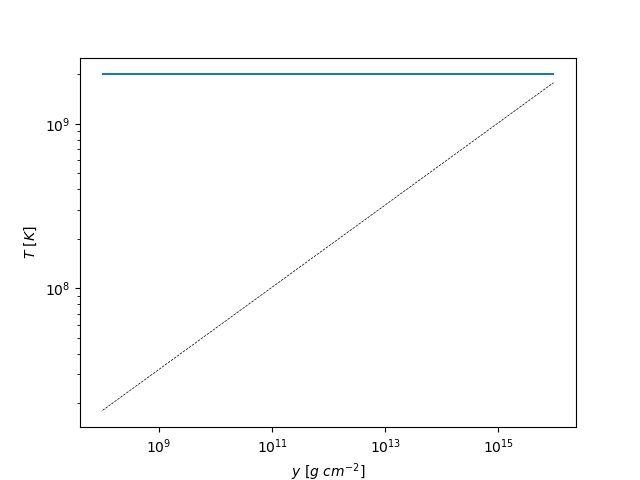

<IPython.core.display.Javascript object>


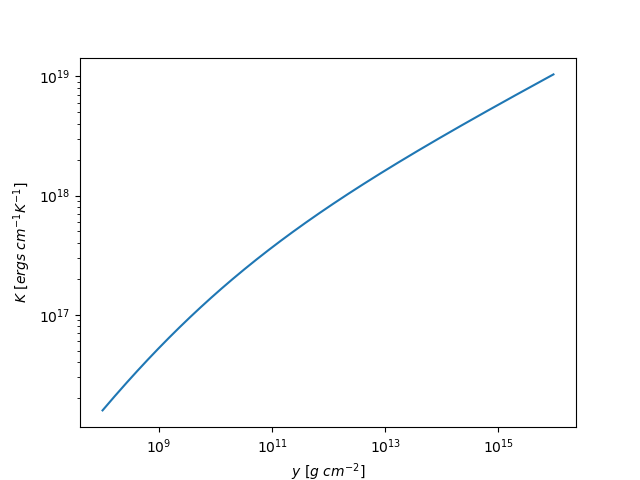

<IPython.core.display.Javascript object>


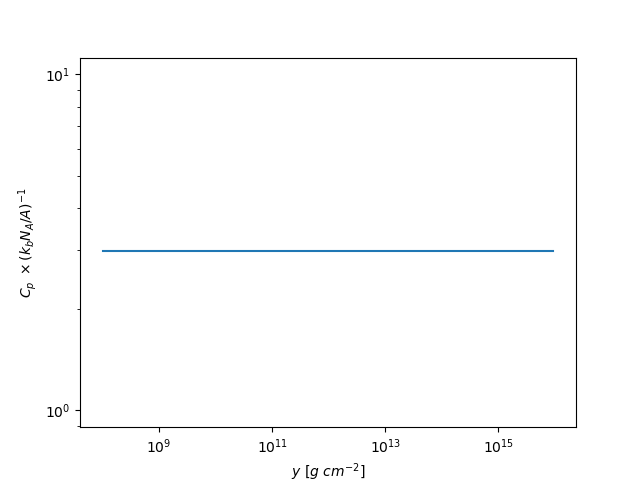

<IPython.core.display.Javascript object>


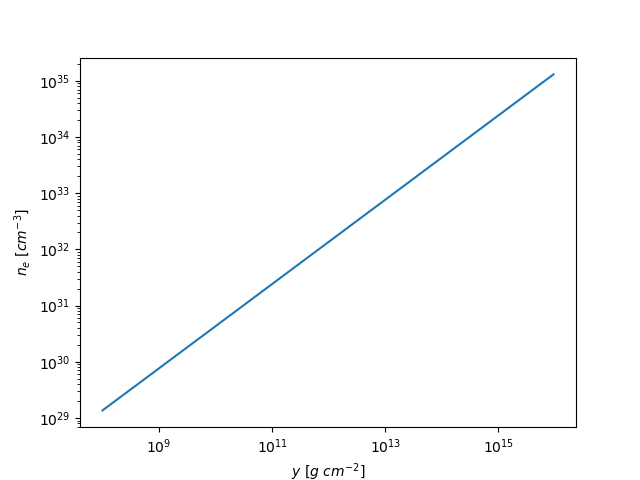

In [142]:
ocean = Ocean(int(3e2),8,16,heatfluxdata,56,26)
ocean.set_IC_flat(2e9)
ocean.plot_T(freezing = 1, save = False)
ocean.plot_k(save = False)
ocean.plot_cp(save = False)
ocean.plot_ne(save = False)

In [143]:
ocean.time_evolve(1e11)

<IPython.core.display.Javascript object>


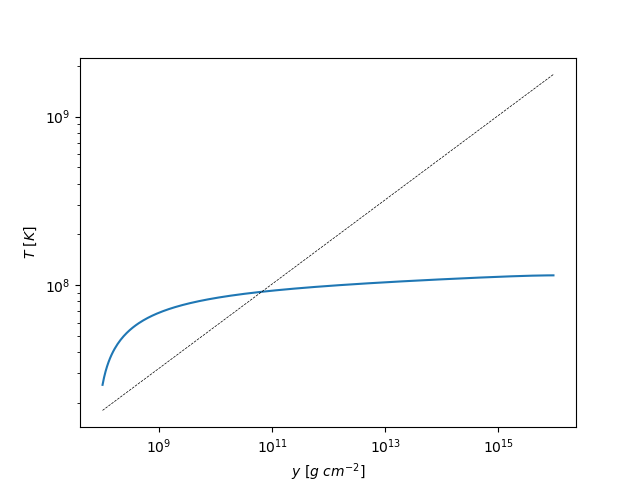

<IPython.core.display.Javascript object>


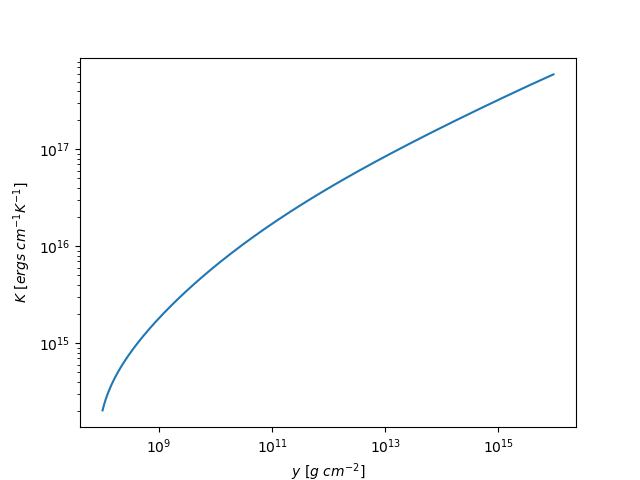

<IPython.core.display.Javascript object>


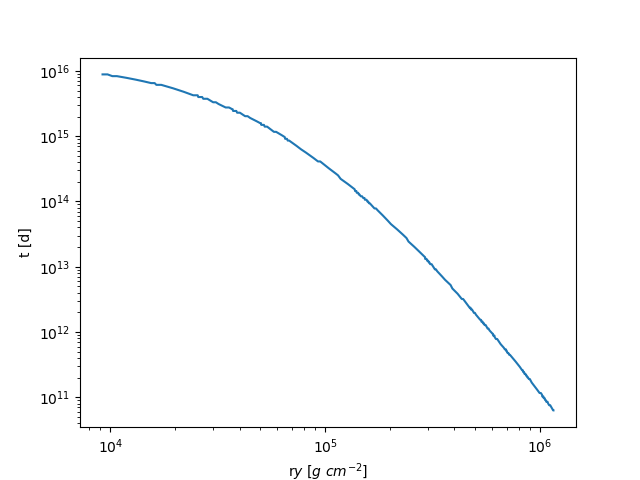

In [144]:
ocean.plot_T(freezing = True, save = False)
ocean.plot_k(save = False)
ocean.plot_freezing_front()

<IPython.core.display.Javascript object>


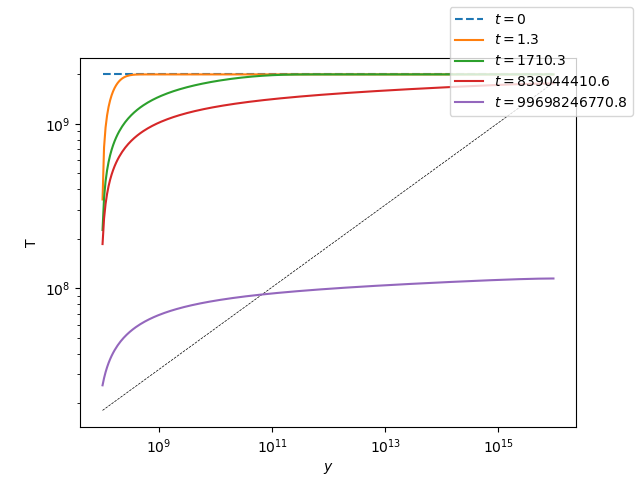

<IPython.core.display.Javascript object>


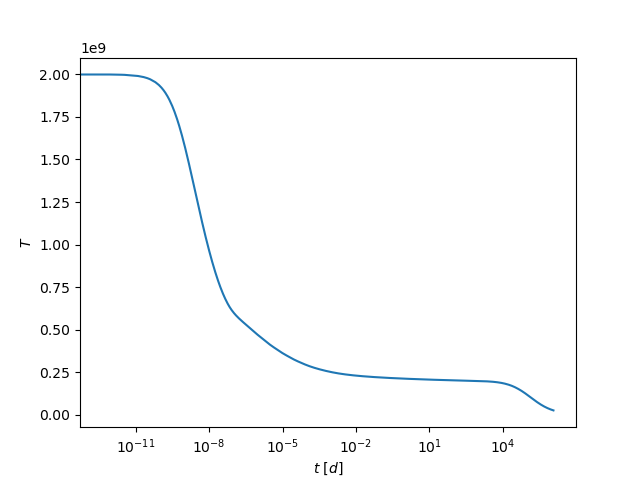

In [100]:
ocean.plot_T_history(4,save = True)
ocean.plot_light_curve(save = True)

<IPython.core.display.Javascript object>


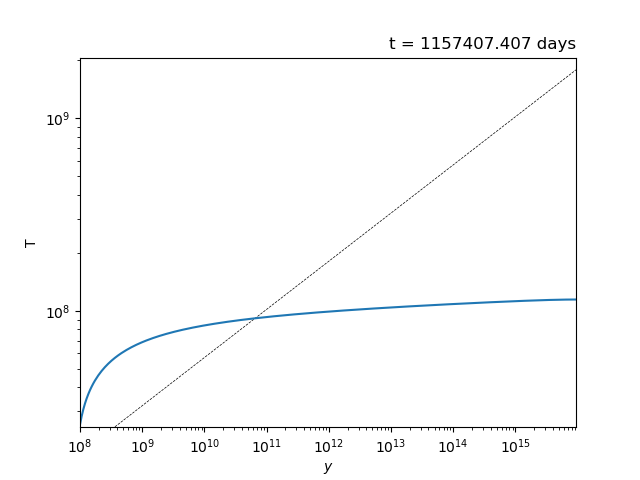

In [95]:
ocean.animate_T('trackingbase',1)

<IPython.core.display.Javascript object>


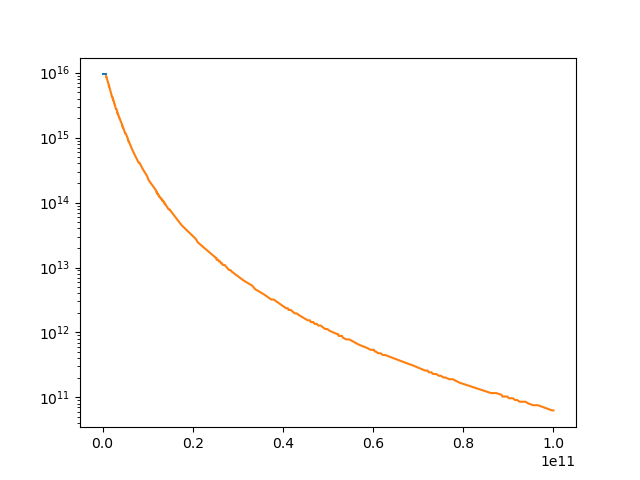

In [133]:
track = np.where(np.diff(ocean.T_evol<ocean.freezing_T,axis = 1)==True)

fig, ax = plt.subplots()
ax.semilogy(ocean.t[track[0]],ocean.y[track[1]])

In [114]:
ocean.T_evol.shape

(1345, 300)

In [118]:
np.diff((ocean.T_evol<ocean.freezing_T),axis = 0).shape

(1344, 300)